In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

train = pd.read_csv('adjtrain2.csv')
test = pd.read_csv('adjtest2.csv')

In [297]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
 13  Cabin_Ex     891 non-null    int64  
 14  Family       891 non-null    int64  
 15  Age_Band     891 non-null    object 
dtypes: float64(2), int64(8), object(6)
memory usage: 111.5+ KB


#### Family 에 대한 해석

1. 적절한 가족수는 생존에 도움이 된다.
2. 동승한 가족이 많거나 혼자 탑승했다면 생존에 악영향


In [245]:
train_and_test = [train, test]

In [298]:
features_drop = ['SibSp','Parch','Ticket','Cabin','Name','Family','Age_Band']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)

In [299]:
train_and_test = [train, test]

### Fare/Age feature 조절

- Fare/Age 고통
1. MinMaxScaler 진행시 이상치가 존재하면 fit 에 문제가 생길수 있다고 한다. 이상치 조정

- Age
1. Age 를 모델에 적용하는데 굳이 Age_Band 를 적용할 필요가 없다. 오버피팅의 문제만 발생시킬 가능성

#### Age

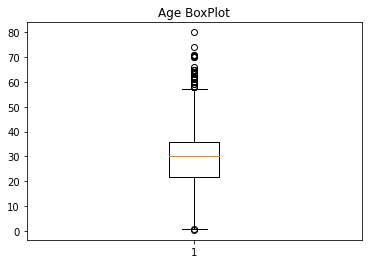

In [300]:
plt.boxplot(train['Age'])
plt.title('Age BoxPlot')
plt.show()


In [301]:
Age_1Q = train['Age'].quantile(.25)
Age_3Q = train['Age'].quantile(.75)
Age_IQR = Age_3Q - Age_1Q

In [302]:
train_and_test = [train, test]

In [303]:
for dataset in train_and_test:
    dataset.loc[dataset['Age'] > Age_3Q + 1.5 * Age_IQR , 'Age'] = Age_3Q + 1.5 * Age_IQR
    dataset.loc[dataset['Age'] < Age_1Q - 1.5 * Age_IQR , 'Age'] = Age_1Q - 1.5 * Age_IQR

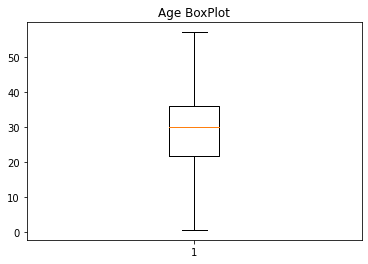

In [304]:
plt.boxplot(train['Age'])
plt.title('Age BoxPlot')
plt.show()


#### Fare

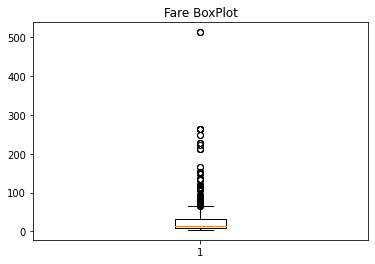

In [305]:
plt.boxplot(train['Fare'])
plt.title('Fare BoxPlot')
plt.show()


In [306]:
Fare_1Q = train['Fare'].quantile(.25)
Fare_3Q = train['Fare'].quantile(.75)
Fare_IQR = Fare_3Q - Fare_1Q

In [307]:
for dataset in train_and_test:
    dataset.loc[dataset['Fare'] > Fare_3Q + 1.5 * Fare_IQR , 'Fare'] = Fare_3Q + 1.5 * Fare_IQR
    dataset.loc[dataset['Fare'] < Fare_1Q - 1.5 * Fare_IQR , 'Fare'] = Fare_1Q - 1.5 * Fare_IQR

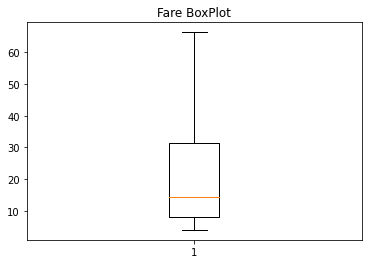

In [308]:
plt.boxplot(train['Fare'])
plt.title('Fare BoxPlot')
plt.show()

In [309]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for dataset in train_and_test:
    scaler.fit(dataset[['Age','Fare']])
    sub_set = scaler.transform(dataset[['Age','Fare']])
    dataset['Age'] = sub_set[:,0]
    dataset['Fare'] = sub_set[:,1]


In [310]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Cabin_Ex
0,1,0,3,0,0.378374,0.051977,S,Mr,0
1,2,1,1,1,0.662464,1.000000,C,Baby&male,1
2,3,1,3,1,0.449396,0.062814,S,Baby&male,0
3,4,1,1,1,0.609197,0.788079,S,Baby&male,1
4,5,0,3,0,0.609197,0.064820,S,Mr,0


In [311]:
train_and_test = [train, test]

In [312]:
for dataset in train_and_test:
    dataset['Pclass'] = dataset['Pclass'].replace(1,'A')
    dataset['Pclass'] = dataset['Pclass'].replace(2,'B')
    dataset['Pclass'] = dataset['Pclass'].replace(3,'C')

In [313]:
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [314]:
train.head()

,PassengerId,Survived,Sex,Age,Fare,Cabin_Ex,Pclass_B,Pclass_C,Embarked_Q,Embarked_S,Title_Mr,Title_Others
0,1,0,0,0.378374,0.051977,0,0,1,0,1,1,0
1,2,1,1,0.662464,1.000000,1,0,0,0,0,0,0
2,3,1,1,0.449396,0.062814,0,0,1,0,1,0,0
3,4,1,1,0.609197,0.788079,1,0,0,0,1,0,0
4,5,0,0,0.609197,0.064820,0,0,1,0,1,1,0


In [315]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle


In [316]:
features_drop = ['PassengerId','Survived']
features_drop2 = ['PassengerId']
train_features = train.drop(features_drop, axis=1)
train_label = train['Survived']
test_features = test.drop(features_drop2, axis=1)

print(train_features.shape, train_label.shape, test_features.shape)

(891, 10) (891,) (418, 10)


In [317]:
def ModelTest(model):

    model.fit(train_features, train_label)
    prediction = model.predict(test_features)
    accuracy = round(cross_val_score(model, train_features, train_label, cv=5).mean()*100,4)
    print ("Accuracy : ", accuracy, "%")
    return prediction


In [318]:
SVC = ModelTest(SVC())

Accuracy :  82.4907 %


In [319]:
submission = pd.DataFrame({"PassengerId" : test["PassengerId"],
                           "Survived" : SVC})
submission.to_csv('C:/Users/JH/Desktop/SVC02.csv',index=False)

In [320]:
train.corr()

,PassengerId,Survived,Sex,Age,Fare,Cabin_Ex,Pclass_B,Pclass_C,Embarked_Q,Embarked_S,Title_Mr,Title_Others
PassengerId,1.000000,-0.005007,-0.042939,0.044002,0.019220,0.019919,-0.000086,-0.029486,-0.033606,0.022204,0.038850,0.070231
Survived,-0.005007,1.000000,0.543351,-0.087956,0.296777,0.316912,0.093349,-0.322308,0.003650,-0.149683,-0.549199,0.013988
Sex,-0.042939,0.543351,1.000000,-0.112922,0.214604,0.140391,0.064746,-0.137143,0.074115,-0.119224,-0.867334,-0.044146
Age,0.044002,-0.087956,-0.112922,1.000000,0.145124,0.234850,0.009179,-0.292859,-0.050771,-0.005488,0.233095,0.175954
Fare,0.019220,0.296777,0.214604,0.145124,1.000000,0.628166,-0.088063,-0.588132,-0.179349,-0.106712,-0.254131,0.111369
Cabin_Ex,0.019919,0.316912,0.140391,0.234850,0.628166,1.000000,-0.172413,-0.539291,-0.129572,-0.101139,-0.137319,0.111841
Pclass_B,-0.000086,0.093349,0.064746,0.009179,-0.088063,-0.172413,1.000000,-0.565210,-0.127301,0.189980,-0.088569,0.043336
Pclass_C,-0.029486,-0.322308,-0.137143,-0.292859,-0.588132,-0.539291,-0.565210,1.000000,0.237449,-0.015104,0.155907,-0.192083
Embarked_Q,-0.033606,0.003650,0.074115,-0.050771,-0.179349,-0.129572,-0.127301,0.237449,1.000000,-0.499421,-0.078338,-0.005860
Embarked_S,0.022204,-0.149683,-0.119224,-0.005488,-0.106712,-0.101139,0.189980,-0.015104,-0.499421,1.000000,0.112870,-0.057508
